<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/13_preliz.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(preliz-notebook)=
# Scegliere le distribuzioni a priori

La definizione delle distribuzioni a priori si riferisce al processo di trasformazione della conoscenza di un particolare dominio in distribuzioni di probabilità. Specificare dei distribuzioni a priori utili è un aspetto centrale della statistica bayesiana. PreliZ è un pacchetto Python progettato per assistere i ricercatori nella scelta delle distribuzioni a priori, fornendo una serie di strumenti per le varie operazioni necessarie per la definizione delle distribuzioini a priori. C

Nell'ambiente virtuale in cui è installato PyMC, possiamo installare PreliZ nel modo seguente:

```bash
pip install "preliz[full,lab]
```

Carichiamo dunque i pacchetti necessari per questo tutorial.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import preliz as pz
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

AttributeError: module 'numpy.__config__' has no attribute 'get_info'

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

Per fare un esempio pratico, consideriamo nuovamente i dati relativi agli artisti della Generazione X nel MOMA. Ricordiamo che i dati corrispondono a 14 successi su 100 prove. Come in precedenza, imposteremo sul parametro $\theta$ (probabilità di appartenere alla Generazione X o successive) una distribuzione Beta(4, 6). 

Il modello, dunque, si presenta come:

$$
\begin{align}
y &\sim Bin(n, \theta) \notag\\
\theta &\sim Beta(4, 6)
\end{align}
$$ 

In [3]:
# Dati
y = 14
ntrials = 100

In [4]:
# Distribuzione a priori
alpha_prior = 4
beta_prior = 6

## Definire il modello

Il modello PyMC viene specificato esattamente come abbiamo fatto in precedenza.

In [5]:
model = pm.Model()

with model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

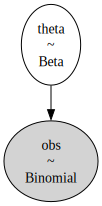

In [6]:
pm.model_to_graphviz(model)

## Esecuzione del campionamento

In precedenza, per il campionamento abbiamo usato la funzione `pm.sample()`.

In [7]:
with model:
    idata1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Sul mio computer questo richiede circa 47 s.

Ripetiamo ora il campionamento, facendo ricorso al campionatore JAX. Per quel che riguarda il codice, useremo l'istruzione `pm.sampling_jax.sample_numpyro_nuts()`.

In [8]:
with model:
    idata2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.141746
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 559.36it/s]


Sampling time =  0:00:04.077252
Transforming variables...
Transformation time =  0:00:00.037559


Si osservi che, nel caso in esame, il processo di campionamento ha impiegato solamente 5 secondi. Sebbene questa accelerazione possa sembrare trascurabile per modelli di semplice costruzione, assume un'importanza significativa quando si tratta di modelli più complessi. In scenari in cui il campionamento può richiedere ore di elaborazione, una diminuzione anche solo del 50% del tempo necessario può avere un impatto considerevole dal punto di vista pratico.

Una volta ottenuto l'oggetto `idata`, questo può essere manipolato come abbiamo fatto in precedenza. Per esempio, per produrre la traccia e la distribuzione a posteriori di $\theta$ chiamiamo `az.plot_trace()`.

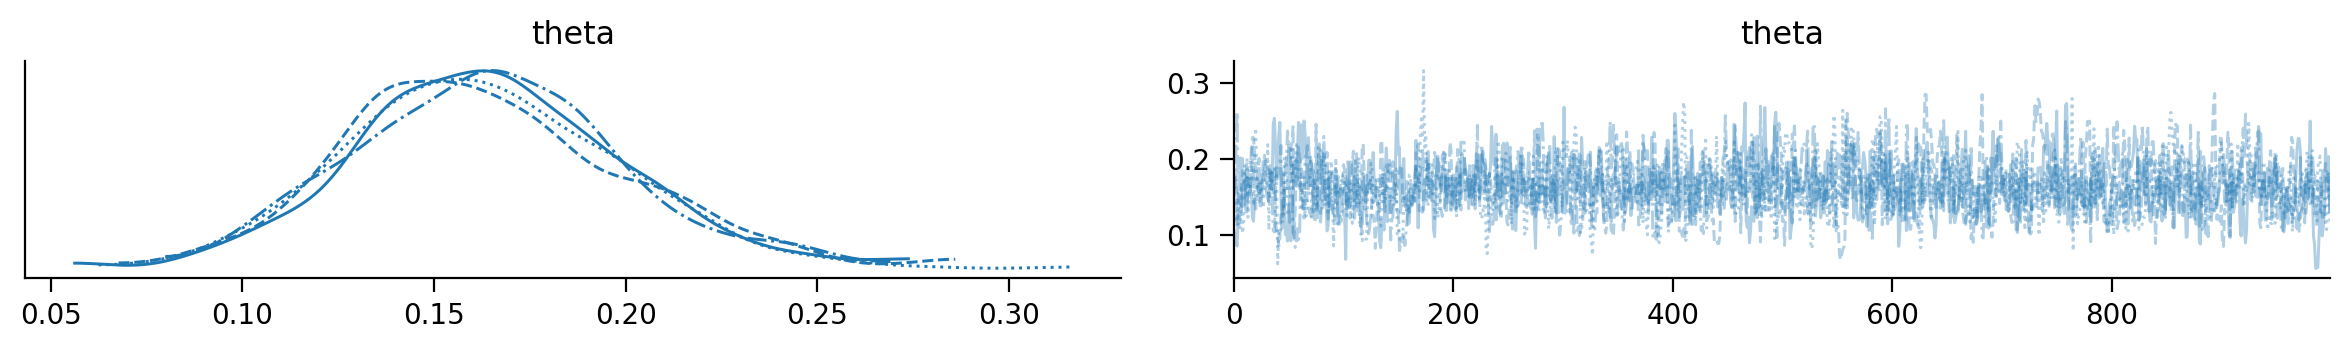

In [22]:
az.plot_trace(idata2)

Per un sommario della distribuzione a posteriori usiamo `az.summary()`.

In [23]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.096,0.227,0.001,0.001,1153.0,1412.0,1.0


Se vogliamo uare blackjax, procediamo nel modo seguente:

In [14]:
with model:
    idata3 = pm.sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:00.785722
Sampling...
Sampling time =  0:00:04.011494
Transforming variables...
Transformation time =  0:00:00.007567


In [15]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.102,0.232,0.001,0.001,1401.0,1643.0,1.0


## Commenti e considerazioni finali 

L'implementazione di JAX in PyMC segna un avanzamento notevole nel processo di campionamento, offrendo una soluzione più veloce ed efficiente rispetto ai metodi tradizionali. La capacità di JAX di accelerare le operazioni di campionamento permette una maggiore agilità nell'analisi, riducendo i tempi di attesa e facilitando l'esplorazione di modelli più complessi. Inoltre, la sua integrazione semplice e senza soluzione di continuità con PyMC rende accessibili questi vantaggi senza richiedere modifiche al codice esistente. 

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p numpyro,blackjax

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Aug 28 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

numpyro : 0.13.0
blackjax: 0.9.6

pymc      : 5.7.2
matplotlib: 3.7.2
numpy     : 1.25.2
seaborn   : 0.12.2
arviz     : 0.16.1
scipy     : 1.11.2

Watermark: 2.4.3

